# Numerical Evaluation of Integrals

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

Integration problems are common in statistics whenever we are dealing with continuous distributions. For example the expectation of a function is an integration problem

$$
E[f(x)] = \int{f(x) \, p(x) \, dx}
$$

In Bayesian statistics, we need to solve the integration problem for the marginal likelihood or evidence

$$
p(X \mid \alpha) = \int{p(X \mid \theta) \, p(\theta \mid \alpha) d\theta}
$$

where $\alpha$ is a hyperparameter and $p(X \mid \alpha)$ appears in the denominator of Bayes theorem

$$
p(\theta | X) = \frac{p(X \mid \theta) \, p(\theta \mid \alpha)}{p(X \mid \alpha)}
$$

In general, there is no closed form solution to these integrals, and we have to approximate them numerically. The first step is to check if there is some **reparameterization** that will simplify the problem. Then, the general approaches to solving integration problems are

1. Numerical quadrature
2. Importance sampling, adaptive importance sampling and variance reduction techniques (Monte Carlo swindles)
3. Markov Chain Monte Carlo
4. Asymptotic approximations (Laplace method and its modern version in variational inference)

This lecture will review the concepts for quadrature and Monte Carlo integration.

Quadrature
----

You may recall from Calculus that integrals can be numerically evaluated using quadrature methods such as Trapezoid and Simpson's's rules. This is easy to do in Python, but has the drawback of the complexity growing as $O(n^d)$ where $d$ is the dimensionality of the data, and hence infeasible once $d$ grows beyond a modest number.

### Integrating functions

In [2]:
from scipy.integrate import quad

In [3]:
def f(x):
    return x * np.cos(71*x) + np.sin(13*x)

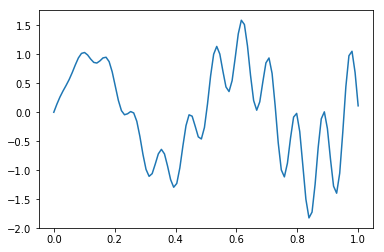

In [4]:
x = np.linspace(0, 1, 100)
plt.plot(x, f(x))
pass

#### Exact solution

In [5]:
from sympy import sin, cos, symbols, integrate

x = symbols('x')
integrate(x * cos(71*x) + sin(13*x), (x, 0,1)).evalf(6)

0.0202549

#### Using quadrature

In [6]:
y, err = quad(f, 0, 1.0)
y

0.02025493910239419

#### Multiple integration

Following the `scipy.integrate` [documentation](http://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html), we integrate

$$
I=\int_{y=0}^{1/2}\int_{x=0}^{1-2y} x y \, dx\, dy
$$

In [7]:
x, y = symbols('x y')
integrate(x*y, (x, 0, 1-2*y), (y, 0, 0.5))

0.0104166666666667

In [8]:
from scipy.integrate import nquad

def f(x, y):
    return x*y

def bounds_y():
    return [0, 0.5]

def bounds_x(y):
    return [0, 1-2*y]

y, err = nquad(f, [bounds_x, bounds_y])
y

0.010416666666666668

## Monte Carlo integration

The basic idea of Monte Carlo integration is very simple and only requires elementary statistics. Suppose we want to find the value of 
$$
I = \int_a^b f(x) dx
$$
in some region with volume $V$. Monte Carlo integration estimates this integral by estimating the fraction of random points that fall below $f(x)$ multiplied by $V$. 


In a statistical context, we use Monte Carlo integration to estimate the expectation
$$
E[g(X)] = \int_X g(x) p(x) dx
$$

with

$$
\bar{g_n} = \frac{1}{n} \sum_{i=1}^n g(x_i)
$$
where $x_i \sim p$ is a draw from the density $p$.

We can estimate the Monte Carlo variance of the approximation as
$$
v_n = \frac{1}{n^2} \sum_{o=1}^n (g(x_i) - \bar{g_n})^2)
$$

Also, from the Central Limit Theorem,

$$
\frac{\bar{g_n} - E[g(X)]}{\sqrt{v_n}} \sim \mathcal{N}(0, 1)
$$

The convergence of Monte Carlo integration is $\mathcal{0}(n^{1/2})$ and independent of the dimensionality. Hence Monte Carlo integration generally beats numerical integration for moderate- and high-dimensional integration since numerical integration (quadrature) converges as $\mathcal{0}(n^{d})$. Even for low dimensional problems, Monte Carlo integration may have an advantage when the volume to be integrated is concentrated in a very small region and we can use information from the distribution to draw samples more often in the region of importance.

An elementary, readable description of Monte Carlo integration and variance reduction techniques can be found [here](https://www.cs.dartmouth.edu/~wjarosz/publications/dissertation/appendixA.pdf).

### Intuition behind Monte Carlo integration

We want to find some integral 

$$I = \int{f(x)} \, dx$$

Consider the expectation of a function $g(x)$ with respect to some distribution $p(x)$. By definition, we have

$$
E[g(x)] = \int{g(x) \, p(x) \, dx}
$$

If we choose $g(x) = f(x)/p(x)$, then we have

$$
\begin{align}
E[g(x)] &= \int{\frac{f(x}{p(x)} \, p(x) \, dx} \\
&= \int{f(x) dx} \\
&= I
\end{align}
$$

By the law of large numbers, the average converges on the expectation, so we have

$$
I \approx \bar{g_n} = \frac{1}{n} \sum_{i=1}^n g(x_i)
$$

If $f(x)$ is a proper integral (i.e. bounded), and $p(x)$ is the uniform distribution, then $g(x) = f(x)$ and this is known as ordinary Monte Carlo. If the integral of $f(x)$ is improper, then we need to use another distribution with the same support as $f(x)$.

In [9]:
from scipy import stats

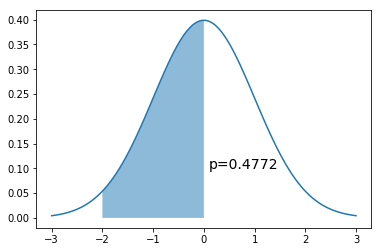

In [10]:
x = np.linspace(-3,3,100)
dist = stats.norm(0,1)
a = -2
b = 0
plt.plot(x, dist.pdf(x))
plt.fill_between(np.linspace(a,b,100), dist.pdf(np.linspace(a,b,100)), alpha=0.5)
plt.text(b+0.1, 0.1, 'p=%.4f' % (dist.cdf(b) - dist.cdf(a)), fontsize=14)
pass

#### Using quadrature

In [11]:
y, err = quad(dist.pdf, a, b)
y

0.47724986805182085

#### Simple Monte Carlo integration

If we can sample directly from the target distribution $N(0,1)$

In [12]:
n = 10000
x = dist.rvs(n)
np.sum((a < x) & (x < b))/n

0.4816

If we cannot sample directly from the target distribution $N(0,1)$ but can evaluate it at any point. 

Recall that $g(x) = \frac{f(x)}{p(x)}$. Since $p(x)$ is $U(a, b)$, $p(x) = \frac{1}{b-a}$. So we want to calculate

$$
\frac{1}{n} \sum_{i=1}^n (b-a) f(x)
$$

In [13]:
n = 10000
x = np.random.uniform(a, b, n)
np.mean((b-a)*dist.pdf(x))

0.4783397843683427

### Intuition for error rate

We will just work this out for a proper integral $f(x)$ defined in the unit cube and bounded by $|f(x)| \le 1$. Draw a random uniform vector $x$ in the unit cube. Then

$$
\begin{align}
E[f(x_i)] &= \int{f(x) p(x) dx} = I \\
\text{Var}[f(x_i)] &= \int{(f(x_i) - I )^2 p(x) \, dx} \\
&= \int{f(x)^2 \, p(x) \, dx} - 2I \int(f(x) \, p(x) \, dx + I^2 \int{p(x) \, dx} \\
&= \int{f(x)^2 \, p(x) \, dx}  + I^2 \\
& \le \int{f(x)^2 \, p(x) \, dx} \\
& \le \int{p(x) \, dx} = 1
\end{align}
$$

Now consider summing over many such IID draws $S_n = f(x_1) + f(x_2) + \cdots + f(x_n)$, \ldots, x_n$. We have

$$
\begin{align}
E[S_n] &= nI \\
\text{Var}[S_n] & \le n
\end{align}
$$

and as expected, we see that $I \approx S_n/n$. From Chebyshev's inequality,

$$
\begin{align}
P \left( \left| \frac{s_n}{n} - I \right| \ge \epsilon \right)  &= 
P \left( \left| s_n - nI \right| \ge n \epsilon \right) & \le \frac{\text{Var}[s_n]}{n^2 \epsilon^2} & \le
\frac{1}{n \epsilon^2} = \delta
\end{align}
$$

Suppose we want 1% accuracy and 99% confidence - i.e. set $\epsilon = \delta = 0.01$. The above inequality tells us that we can achieve this with just $n = 1/(\delta \epsilon^2) = 1,000,000$ samples, regardless of the data dimensionality.

### Example

We want to estimate the following integral $\int_0^1 e^x dx$. 

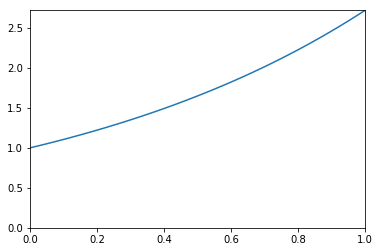

In [14]:
x = np.linspace(0, 1, 100)
plt.plot(x, np.exp(x))
plt.xlim([0,1])
plt.ylim([0, np.exp(1)])
pass

#### Analytic solution

In [15]:
from sympy import symbols, integrate, exp

x = symbols('x')
expr = integrate(exp(x), (x,0,1))
expr.evalf()

1.71828182845905

#### Using quadrature

In [16]:
from scipy import integrate

y, err = integrate.quad(exp, 0, 1)
y

1.7182818284590453

#### Monte Carlo integration

In [17]:
for n in 10**np.array([1,2,3,4,5,6,7,8]):
    x = np.random.uniform(0, 1, n)
    sol = np.mean(np.exp(x))
    print('%10d %.6f' % (n, sol))

        10 2.016472
       100 1.717020
      1000 1.709350
     10000 1.719758
    100000 1.716437
   1000000 1.717601
  10000000 1.718240
 100000000 1.718152


### Monitoring variance in Monte Carlo integration

We are often interested in knowing how many iterations it takes for Monte Carlo integration to "converge". To do this, we would like some estimate of the variance, and it is useful to inspect such plots. One simple way to get confidence intervals for the plot of Monte Carlo estimate against number of iterations is simply to do many such simulations.

For the example, we will try to estimate the function (again)

$$
f(x) = x \cos 71 x + \sin 13x, \ \  0 \le x \le 1
$$

In [18]:
def f(x):
    return x * np.cos(71*x) + np.sin(13*x)

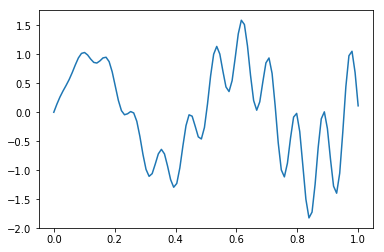

In [19]:
x = np.linspace(0, 1, 100)
plt.plot(x, f(x))
pass

#### Single MC integration estimate

In [20]:
n = 100
x = f(np.random.random(n))
y = 1.0/n * np.sum(x)
y

-0.15505102485636882

#### Using multiple independent sequences to monitor convergence

We vary the sample size from 1 to 100 and calculate the value of $y = \sum{x}/n$ for 1000 replicates. We then plot the 2.5th and 97.5th percentile of the 1000 values of $y$ to see how the variation in $y$ changes with sample size. The blue lines indicate the 2.5th and 97.5th percentiles, and the red line a sample path.

In [21]:
n = 100
reps = 1000

x = f(np.random.random((n, reps)))
y = 1/np.arange(1, n+1)[:, None] * np.cumsum(x, axis=0)
upper, lower = np.percentile(y, [2.5, 97.5], axis=1)

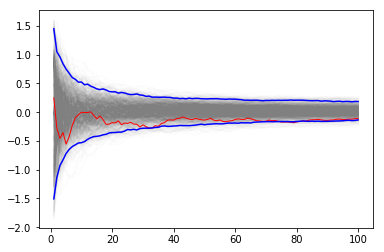

In [22]:
plt.plot(np.arange(1, n+1), y, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), y[:, 0], c='red', linewidth=1);
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b')
pass

#### Using bootstrap to monitor convergence

If it is too expensive to do 1000 replicates, we can use a bootstrap instead.

In [23]:
xb = np.random.choice(x[:,0], (n, reps), replace=True)
yb = 1/np.arange(1, n+1)[:, None] * np.cumsum(xb, axis=0)
upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)

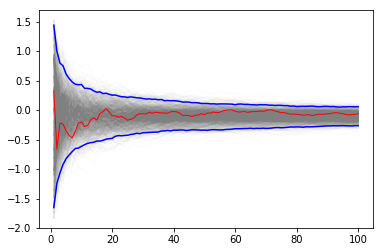

In [24]:
plt.plot(np.arange(1, n+1)[:, None], yb, c='grey', alpha=0.02)
plt.plot(np.arange(1, n+1), yb[:, 0], c='red', linewidth=1)
plt.plot(np.arange(1, n+1), upper, 'b', np.arange(1, n+1), lower, 'b')
pass

## Variance Reduction

With independent samples, the variance of the Monte Carlo estimate is 


$$
\begin{align}
\text{Var}[\bar{g_n}] &= \text{Var} \left[ \frac{1}{N}\sum_{i=1}^{N} \frac{f(x_i)}{p(x_i)} \right] \\
&= \frac{1}{N^2} \sum_{i=1}^{N}  \text{Var} \left[ \frac{f(x_i)}{p(x_i)} \right] \\
&= \frac{1}{N^2} \sum_{i=1}^{N} \text{Var}[Y_i] \\
&= \frac{1}{N} \text{Var}[Y_i]
\end{align}
$$

where $Y_i = f(x_i)/p(x_i)$. In general, we want to make $\text{Var}[\bar{g_n}]$ as small as possible for the same number of samples. There are several variance reduction techniques (also colorfully known as Monte Carlo swindles) that have been described - we illustrate the change of variables and importance sampling techniques here.

### Change of variables

The Cauchy distribution is given by 
$$
f(x) = \frac{1}{\pi (1 + x^2)}, \ \ -\infty \lt x \lt \infty 
$$

Suppose we want to integrate the tail probability $P(X > 3)$ using Monte Carlo. One way to do this is to draw many samples form a Cauchy distribution, and count how many of them are greater than 3, but this is extremely inefficient.

#### Only 10% of samples will be used

In [25]:
import scipy.stats as stats

h_true = 1 - stats.cauchy().cdf(3)
h_true

0.10241638234956674

In [26]:
n = 100

x = stats.cauchy().rvs(n)
h_mc = 1.0/n * np.sum(x > 3)
h_mc, np.abs(h_mc - h_true)/h_true

(0.1, 0.02359370926927643)

#### A change of variables lets us use 100% of draws

We are trying to estimate the quantity

$$
\int_3^\infty \frac{1}{\pi (1 + x^2)} dx
$$

Using the substitution $y = 3/x$ (and a little algebra), we get

$$
\int_0^1 \frac{3}{\pi(9 + y^2)} dy
$$

Hence, a much more efficient MC estimator is 

$$
\frac{1}{n} \sum_{i=1}^n \frac{3}{\pi(9 + y_i^2)}
$$

where $y_i \sim \mathcal{U}(0, 1)$.

In [27]:
y = stats.uniform().rvs(n)
h_cv = 1.0/n * np.sum(3.0/(np.pi * (9 + y**2)))
h_cv, np.abs(h_cv - h_true)/h_true

(0.10252486615772155, 0.0010592427272478476)

### Importance sampling

Suppose we want to evaluate

$$
I = \int{h(x)\,p(x) \, dx}
$$

where $h(x)$ is some function and $p(x)$ is the PDF of $y$. If it is hard to sample directly from $p$, we can introduce a new density function $q(x)$ that is easy to sample from, and write

$$
I = \int{h(x)\, p(x)\, dx} = \int{h(x)\, \frac{p(x)}{q(x)} \, q(x) \, dx}
$$

In other words, we sample from $h(y)$ where $y \sim q$ and weight it by the likelihood ratio $\frac{p(y)}{q(y)}$, estimating the integral as

$$
\frac{1}{n}\sum_{i=1}^n \frac{p(y_i)}{q(y_i)} h(y_i)
$$

Sometimes, even if we can sample from $p$ directly, it is more efficient to use another distribution.

#### Example

Suppose we want to estimate the tail probability of $\mathcal{N}(0, 1)$ for $P(X > 5)$. Regular MC integration using samples from $\mathcal{N}(0, 1)$ is hopeless since nearly all samples will be rejected. However, we can use the exponential density truncated at 5 as the importance function and use importance sampling. Note that $h$ here is simply the identify function.

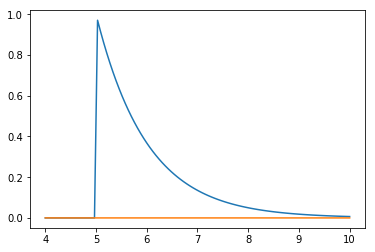

In [28]:
x = np.linspace(4, 10, 100)
plt.plot(x, stats.expon(5).pdf(x))
plt.plot(x, stats.norm().pdf(x))
pass

#### Expected answer

We expect about 3 draws out of 10,000,000 from $\mathcal{N}(0, 1)$ to have a value greater than 5. Hence simply sampling from $\mathcal{N}(0, 1)$ is hopelessly inefficient for Monte Carlo integration.

In [29]:
%precision 10

'%.10f'

In [30]:
v_true = 1 - stats.norm().cdf(5)
v_true

0.0000002867

#### Using direct Monte Carlo integration

In [31]:
n = 10000
y = stats.norm().rvs(n)
v_mc = 1.0/n * np.sum(y > 5)
# estimate and relative error
v_mc, np.abs(v_mc - v_true)/v_true 

(0.0000000000, 1.0000000000)

#### Using importance sampling

In [32]:
n = 10000
y = stats.expon(loc=5).rvs(n)
v_is = 1.0/n * np.sum(stats.norm().pdf(y)/stats.expon(loc=5).pdf(y))
# estimate and relative error
v_is, np.abs(v_is- v_true)/v_true

(0.0000002850, 0.0056329867)